<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 6: Enhancing and Segmenting Images </strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 1:</small><br/>Discovering Auto-Encoders</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    In Chapter 6 of the book, we introduced <em><strong>encoders-decoders</em></strong> and their variant the <em><strong>auto-encoders</em></strong>. We detailed how auto-encoders' goal is to properly encode and then decode images without impacting their quality, despite their bottleneck (their latent space of lower dimensionality).
<br/><br/>
In this first notebook for Chapter 6, we will present how to build a simple fully-connected encoder-decoder, and how to apply it to the auto-encoding of <em>MNIST</em> images. We will finally demonstrate how this network can be used after training to embed the dataset and highlight its structure.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [2]:
!pip install -U cython

# Chap6: Enhancing and Segmentation Images


- list
    - Transforming images with encoders-decoders
        - encoder-decoder 소개
        - Encoding Decoding
        - Auto-Encoding
        - purpose
    - Basic example - image denosing
        - simplistic fully-connected auto-encoder
        - application to image denosing
    - convolutional encoders-decoders
        - unpooling, transposing, and dilating
            - transposed convolution(deconvolution)
            - unpooling
            - upsampling and resizing
            - dilated/ atrous convolution
        - Exemplary architecture -FCN and U-Net
            - fully convolutional networks
            - U-Net
        - intermediary example -image super-resolution
            - FCN implementation
            - application to upscaling images

- 이번 챕터에서는 encoder-decoders 모델의 다양한 활용(denoising, instance segmentation)들을 살펴보고 이를 구현해봅니다.
- 챕터에서는 자율주행운전을 위한 semantic segmentation에 encoder-decoder를 적용한 몇 가지 예시를 함께 다룹니다.


## Transforming images with encoders-decoders

- 대다수 computer vision은 픽셀 수준의 결과를 요구합니다. 예를 들어, semantic segmentation 방법은 이미지의 각 픽셀을 분류합니다. 그리고 약간의 픽셀들을 변형해 이미지를 리턴합니다.
- 이번 섹션에서는 encoder와 decoder를 이용해 픽셀 수준의 작업을 수행해보고 CNN이 이러한 응용에 어떻게 적용될 수 있는지에 대해 알아봅니다.

### Encoding and Decoding

- encoder는 입력 샘플을 잠재 공간에 매핑하는 함수입니다. 즉, encoder에 의해 정의된 숨겨진 구조화된 값의 집합입니다.
- decoder는 잠재 공간에서 사전에 정의된 타겟 도메인으로 element를 매핑한 상호보완적인 함수입니다.


- 머신러닝에서 encoder-decoder 신경망은 텍스트 번역과 같은 것에 사용됩니다. encoder 문장을 입력으로 받으면 학습을 위해 이를 잠재 공간으로 가져가고 잠재 공간에는 문장의 의미가 feature vector로 인코드된 것을 저장합니다.
- decoder 신경망은 encoder와 동시에 학습되어지고 인코드된 벡터를 타켓 언어의 문장으로 전환시킵니다.

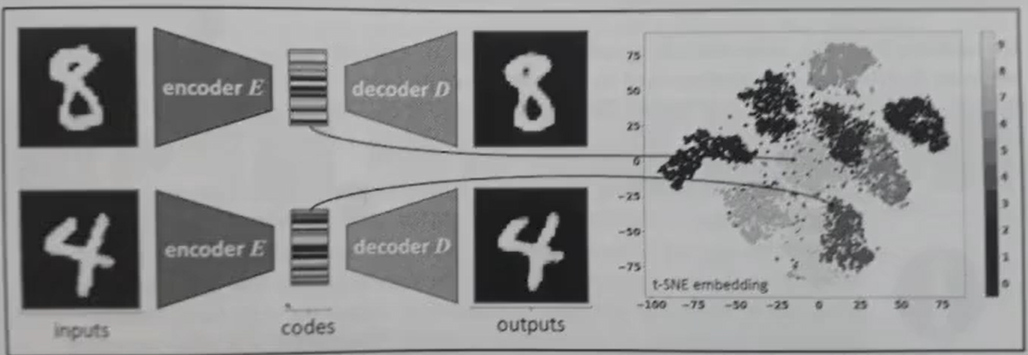

- encoder는 28x28크기의 이미지를 32값의 벡터로 변환하도록 학습되어지고 decoder는 다시 이미지로 돌아오게 학습되어집니다.
- 위의 오른쪽 그림은 잠재공간을 클래스 레이블과 함께 plot한 것입니다. 즉 잠재공간의 벡터들을 클래스 값을 가집니다. 32차원의 벡터를 t-SNE를 통해 2차원 평면에 투영합니다.


- encoder는 semantic 정보를 추출/압축하도록 학습/디자인 되었고, decoder는 압축된 정보를 타겟 도메인의 정보로 압축해제/완성합니다.

## Auto-encoding

- Auto-encoders(AEs)는 encoder-decoders의 특별한 종류입니다. 
- 위에서 본 encoder-decoders 그림에서 입력과 타켓 도메인이 같은 것을 알 수 있고, 위 구조의 목적이 영상의 품질에 영향을 주지 않고 알맞게 encode 하고  decode하는 것입니다. 
- 입력은 압축된 표현으로 축소된다.(feature vector로 변환)
- 나중에 original input이 요청되면, decoder에서 압축된 것을 통해 재구성한다.


- JPEG tools는 auto-encoder라고 불리는데, 이 tool의 목적은 품질 손실을 최대한 줄이면서 영상을 encoder 후 decode하는 것이다.
- 입력과 출력 데이터의 차이는 전형적인 auto-encoder 알고리즘에 의해 최소화되는 loss이다.
- 영상에서 이러한 차이는 cross-entropy loss, L1/L2 loss에 의해 계산된다.
- 머신러닝에서, auto-encoding network는 loss를 표현하기 손쉬울 뿐만 아니라 label을 필요로 하지 않기 때문에 학습하기 매우 편리합니다. 입력 이미지 자체가 loss를 계산하는데 사용되는 target입니다.


- auto-encoder의 잠재 공간(latent space)이 더 작기 때문에, encoding sub-network는 데이터를 적절하게 압축하는 법을 배워야 하는 반면, decoder는 다시 압축 해제하기 위해 적절한 매핑을 배워야 합니다.


## purpose

- encoder-decoder 구조는 굉장히 다양하게 활용된다.
- 이미지 변환에 사용되는데, 하나의 도메인으로부터 맵핑하거나 다른 형식으로 맵핑한다.
- 예를들어 이러한 모델은 종종 깊이 회귀 분석, 즉 각 픽셀에 대한 카메라와 영상 content 사이의 거리를 추정하는데 적용됩니다.

- 이것은 증강 현실 애플리케이션에 있어 중요한 작업으로, 예를 들어, 주변 환경의 3D 표현을 구축하여 환경과 더 잘 상호작용할 수 있기 때문입니다.

- encoder-decoder는 sementic segmentation에도 주로 사용됩니다. 
- 이 경우에 신경망은 depth를 반환하는게 아닌 각 픽셀에 대해 예상되는 클래스를 반환하도록 학습합니다.
- 마지막으로, encoder-decoder는 예술적 사용에 유명합니다. 낙서를 가상현실 이미지로 변환하거나 밤에 찍은 사진에 상응하는 낮 시간 추정에 사용됩니다.

- 이제 auto-encdoer에 대해 생각해보면 왜 신경망은 입력 이미지를 출력하도록 학습되어질까요?
- 정답은 auto-encoder의 bottleneck property에 있습니다.
- 인코딩 및 디코딩 구성 요소는 전체적으로 학습되어지며 사용 사례에 따라 별도로 적용됩니다.
    -  병목 현상(bottleneck)은 전체 네트워크를 통과 할 수있는 정보의 양을 제한하여 입력 데이터의 학습된 압축을 이끌어 내는 역할한다.


- bottleneck 때문에 encoder는 데이터를 압축하면서 가능하면 많은 데이터를 유지합니다. 그러므로, 학습 데이터 세트에 반복적인 패턴이 있는 경우, 네트워크는 인코딩을 개선하기 위해 이러한 상관 관계를 밝혀내려고 할 것입니다
- auto-encoder의 encoder 부분은 학습될 도메인으로부터 이미지의 low-dimensional한 표현을 얻는데 사용된다.
- low-dimensional한 표현은 이미지의 content similarity 보존에 좋다.
- auto-encoder의 decoder에 대해 학습시, genrative task에 사용한다. 학습하는 동안 latent space가 만들어졌다면, 여기서 랜덤하게 뽑아진 벡터들은 디코더에 의해 이미지로 바뀝니다. decoder를 새로운 이미지 생산을 위해 학습하는 것은 쉽지않고, 신중한 엔지니어링이 요구됩니다. 

- 하지만, denoising auto-encoder는 가장 흔한 AE 예입니다.
- 이러한 모델은 특히 입력 이미지가 네트워크로 전달되기 전에 손실된 변환을 거칩니다.
- 이러한 모델은 여전히 원본 이미지를 반환하도록 교육받으므로 손실된 작업을 취소하고 일부 누락된 정보를 복구하는 방법을 배우게 됩니다.
- 일반적인 모델은 백색 또는 가우시안 잡음을 제거하거나 손실된 정보를 복구합니다.
- 몇 가지 auto-encoder는 영상 upscaling에도 사용됩니다. -> image super resolution



### Basic example - image denoising

- mnist 이미지의 노이즈를 제거하는 auto-encoder를 설명합니다.

### simplistic fully connected auto-encoder

- 간단한 auto-encoder 구조를 케라스로 구현한 얕고 완전 연결층을 사용해 만들어 봅니다.

In [2]:
#환경설정
import tensorflow as tf
import os
import math
import numpy as np
from matplotlib import pyplot as plt

# Choosing which GPU this notebook can access
# (useful when running multiple experiments in parallel, on different GPUs):
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  #0번째 GPU 사용

# Some hyper-parameters:
batch_size  = 32            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 50            # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

In [3]:
#데이터 전처리
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_height, img_width = x_train.shape[1:] #shape의 첫번째 인덱스부터 
img_channels = 1
input_shape  = (img_height, img_width, img_channels) #28,28,1

# For the following experiments, we will however not use the class labels:
del y_train #이름 삭제
del y_test

# Normalizing the image data:
x_train, x_test = x_train / 255.0, x_test / 255.0 #0~1사이의 실수값으로 정규화

# Even though we will use again a basic fully-coonected network, we need to preserve the image format
# of the sample this time, to use the Keras image pre-processing tool to add noise. Therefore, 
# the augmented images will be flattened by the network itself via a initial Flatten() layer.
x_train = x_train.reshape((-1, img_height, img_width, img_channels))
x_test = x_test.reshape((-1, img_height, img_width, img_channels))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of testing set: {}".format(x_test.shape))

# Setting some variables:
batch_size = 64
train_steps_per_epoch = len(x_train) // batch_size
val_steps_per_epoch = len(x_test) // batch_size

Shape of training set: (60000, 28, 28, 1)
Shape of testing set: (10000, 28, 28, 1)


In [8]:
code_size = 32 #latent space

In [9]:
#auto-encoder 구현
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

inputs = Input(shape=input_shape, name='input') #입력층 28x28x1  

# As previously mentioned, the image flattening is done here:
inputs_flat = Flatten()(inputs) #input을 1차원으로

# Encoding layers: 압축과정
enc_1 = Dense(128, activation='relu', name='enc_dense1')(inputs_flat) #128개 유닛
enc_2 = Dense(64, activation='relu', name='enc_dense2')(enc_1) #64개 유닛
code = Dense(code_size, activation='relu', name='enc_dense3')(enc_2)

# Decoding layers: 복구과정
dec_1 = Dense(64, activation='relu', name='dec_dense1')(code)
dec_2 = Dense(128, activation='relu', name='dec_dense2')(dec_1)
decoded = Dense(np.prod(input_shape), activation='sigmoid', name='dec_dense3')(dec_2) #784(배열 원소간 곱)
# note: we use a sigmoid for the last activation, as we want the output values
# to be between 0 and 1, like the input ones.

# Finally, we reshape the decoded data so it has the same shape as the input samples:
decoded_reshape = Reshape(input_shape)(decoded)

# Auto-encoder model:
autoencoder = Model(inputs, decoded_reshape) #(입력, 출력, ....)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
enc_dense1 (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_dense2 (Dense)           (None, 64)                8256      
_________________________________________________________________
enc_dense3 (Dense)           (None, 32)                2080      
_________________________________________________________________
dec_dense1 (Dense)           (None, 64)                2112      
_________________________________________________________________
dec_dense2 (Dense)           (None, 128)               8320  

In [11]:
np.prod(input_shape)

784

In the chapter, we mentioned that while trained together as an auto-encoder, the encoder and the decoder are usually used separately afterwards. Therefore, it is often convenient to define a separate model for each, wrapping up their respective layers.

For the encoder, it is simply a matter of wrapping into a model the layers from input to code:


In [7]:
encoder = Model(inputs, code)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
enc_dense1 (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_dense2 (Dense)           (None, 64)                8256      
_________________________________________________________________
enc_dense3 (Dense)           (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


### Application to image denoising


- image denoising을 위한 이전 모델 학습은 훈련 이미지의 노이즈가 들어간 사본을 만들고 대신 네트어크의 입력으로 전달합니다. 

In [16]:
a=np.random.normal(loc=0.0, scale=0.5, size=[28,28,1])
a.shape

(28, 28, 1)

In [6]:
#입력 데이터에 노이즈를 추가하기 위한 함수 정의
def add_noise(img, min_noise_factor=.3, max_noise_factor=.6):
    """
    Add some random noise to an image, from a uniform distribution.
    :param img:               Image to corrupt 
    :param min_noise_factor:  Min. value for the noise random average amplitude 노이즈 무작위 평균 진폭 값
    :param max_noise_factor:  Max. value for the noise random average amplitude
    :return:                  Corrupted image
    """
    # Generating and applying noise to image:
    noise_factor = np.random.uniform(min_noise_factor, max_noise_factor) #0.3~0.6 사이의 균등분포에서 noise-factor 1개
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=img.shape) #입력 이미지와 같은 shape의 정규분포 생성
    img_noisy = img + noise # 노이즈 추가
    
    # Making sure the image value are still in the proper range:
    img_noisy = np.clip(img_noisy, 0., 1.) #0~1사이의 실수값으로 cliping
    
    return img_noisy

- 이제 사용할 데이터를 시각화하고 직접 노이즈를 추가해보겠습니다.

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#기존의 figure 방식보다 격자단위로 한 주제를 정확히 보기 위해 사용


def plot_image_grid(images, titles=None, figure=None,
                    grayscale=False, transpose=False):
    """
    Plot a grid of n x m images.
    :param images:       Images in a n x m array
    :param titles:       (opt.) List of m titles for each image column 각 영상 열에 대한 제목 리스트
    :param figure:       (opt.) Pyplot figure (if None, will be created) 
    :param grayscale:    (opt.) Flag to draw the images in grayscale
    :param transpose:    (opt.) Flag to transpose the grid
    :return:             Pyplot figure filled with the images
    """
    num_cols, num_rows = len(images), len(images[0]) #열과 행
    img_ratio = images[0][0].shape[1] / images[0][0].shape[0] #행/열
    
    #전치를 사용하는 경우
    if transpose:
        vert_grid_shape, hori_grid_shape = (1, num_rows), (num_cols, 1)
        figsize = (int(num_rows * 5 * img_ratio), num_cols * 5)
        wspace, hspace = 0.2, 0.
    else:
        vert_grid_shape, hori_grid_shape = (num_rows, 1), (1, num_cols)
        figsize = (int(num_cols * 5 * img_ratio), num_rows * 5)
        hspace, wspace = 0.2, 0.

    if figure is None:
        figure = plt.figure(figsize=figsize)
    imshow_params = {'cmap': plt.get_cmap('gray')} if grayscale else {} #딕셔너리 형태의 컬러맵
    grid_spec = gridspec.GridSpec(*hori_grid_shape, wspace=0, hspace=0) #수평 grid shape의 행열
    #매개변수를 원소를 대입 *
        
    #서브 플롯 레이아웃 매개 변수가 지정된 SubplotSpec에 의해 지정된 위치에서 상속 된 GridSpec.
    for j in range(num_cols):
        grid_spec_j = gridspec.GridSpecFromSubplotSpec(
            *vert_grid_shape, subplot_spec=grid_spec[j], wspace=wspace, hspace=hspace)

        for i in range(num_rows):
            ax_img = figure.add_subplot(grid_spec_j[i])
            # ax_img.axis('off')
            ax_img.set_yticks([])
            ax_img.set_xticks([])
            if titles is not None:
                if transpose:
                    ax_img.set_ylabel(titles[j], fontsize=25)
                else:
                    ax_img.set_title(titles[j], fontsize=15)
            ax_img.imshow(images[j][i], **imshow_params) #named parameter원소 **

    figure.tight_layout()
    return figure

c:\users\82108\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


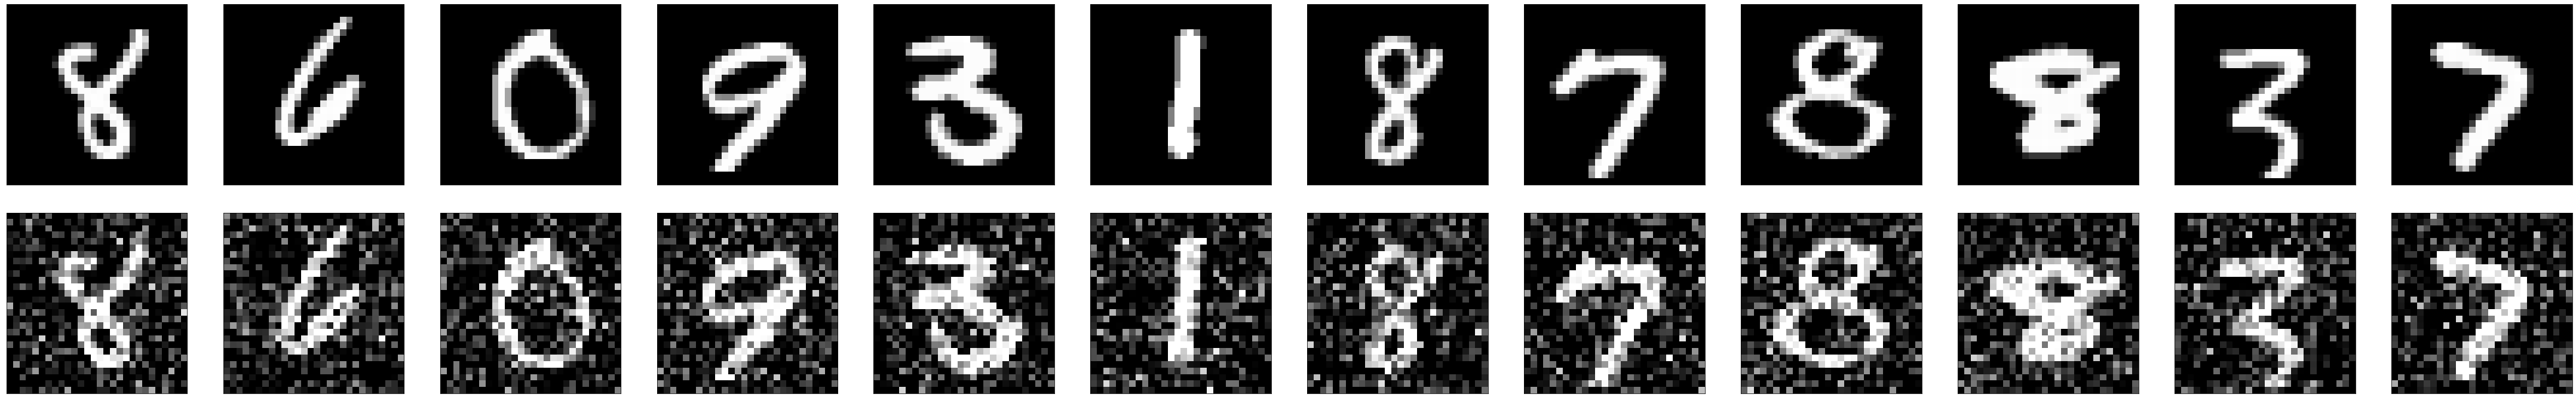

In [19]:
#노이즈 추가된 이미지 출력
num_show = 12
random_image_indices = np.random.choice(len(x_test), size=num_show) #10000개의 데이터 중 12개 랜덤하게 뽑음

orig_samples = x_test[random_image_indices] #원본 영상
noisy_samples = add_noise(orig_samples) #잡음 추가 영상

#np.squeeze 차원 감소 axis=none이면 1차원으로 축소
fig = plot_image_grid([np.squeeze(orig_samples), np.squeeze(noisy_samples)],
                      grayscale=True, transpose=True)
fig.show()

- 약간의 salt&pepper 잡음이 추가된 것을 확인할 수 있습니다. 이 과정이 바로 이미지에 잡음을 추가하는 과정입니다.
- 이제 이 노이즈를 제거하는 denoising을 위에서 설계한 auto-encoder를 통해 구현해봅니다.

- 학습 전 데이터를 노이즈 데이터로 모두 바꾸는 전처리 과정을 추가합니다.
- 이를 구현하기 위해 호출될 때마다 새로운 요소를 생성하는 Python 객체인 generator를 사용할 것입니다. Keras 모델은 데이터 세트(model.fit()) 또는 생성기(model.fit_generator())에 대해 직접 교육할 수 있습니다.
- Keras는 이미지 폴더, 이미지 배열 등을 통해 반복할 수 있는 몇 가지 사전 구현된 generator를 제공합니다. 여기서는 Image Data Generator를 사용하여 과도한 수의 배열을 반복하여 배치를 생성할 수 있습니다. 또한 이 생성기는 각 배치를 산출하기 전에 사전 처리하도록 구성할 수도 있습니다. 

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We define our Keras generator, passing our noisy function as pre-processing step:
train_datagen = ImageDataGenerator(preprocessing_function=add_noise)
#입력이 주어지면 자동으로 주어진 함수를 적용

#산출된 배치의 방식을 지정
# Then we pass our dataset to the generator and specify how the yielded batch should be
# (batch size, shuffling or not, etc.).
#flow 함수: 데이터와 라벨을 받아 배치 산출
train_generator = train_datagen.flow(x_train, x_train, 
                                     batch_size=batch_size, shuffle=True)
train_generator

NameError: name 'add_noise' is not defined

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
help(ImageDataGenerator)

Help on class ImageDataGenerator in module tensorflow.python.keras.preprocessing.image:

class ImageDataGenerator(keras_preprocessing.image.image_data_generator.ImageDataGenerator)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |   The data will be looped over (in batches).
 |  
 |  Args:
 |      featurewise_center: Boolean.
 |          Set input mean to 0 over the dataset, feature-wise.
 |      samplewise_center: Boolean. Set each sample mean to 0.
 | 

In [9]:

train_datagen = ImageDataGenerator(preprocessing_function=add_noise)
help(train_datagen.flow)

Help on method flow in module tensorflow.python.keras.preprocessing.image:

flow(x, y=None, batch_size=32, shuffle=True, sample_weight=None, seed=None, save_to_dir=None, save_prefix='', save_format='png', subset=None) method of tensorflow.python.keras.preprocessing.image.ImageDataGenerator instance
    Takes data & label arrays, generates batches of augmented data.
    
    Args:
        x: Input data. Numpy array of rank 4 or a tuple. If tuple, the first
          element should contain the images and the second element another numpy
          array or a list of numpy arrays that gets passed to the output without
          any modifications. Can be used to feed the model miscellaneous data
          along with the images. In case of grayscale data, the channels axis of
          the image array should have value 1, in case of RGB data, it should
          have value 3, and in case of RGBA data, it should have value 4.
        y: Labels.
        batch_size: Int (default: 32).
        s

- 입력 pipeline은 이렇게 구현되어지고, 이젠 검증 데이터를 준비해야합니다.
- 측정도구를 한 epoch에서 다른 epoch로 일관되게 비교할 수 있도록 검증 이미지를 노이즈로 한 번만 증강하고 결과 영상을 저장해 각 epoch에서 재사용할 수 있도록 했습니다.

In [22]:
x_test_noisy = add_noise(x_test)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator() #검증 데이터에는 전처리 함수 적용x
val_generator = train_datagen.flow(x_test_noisy, x_test,
                                   batch_size=batch_size, shuffle=False)

- 이제 학습을 진행하고 결과를 확인해보겠습니다
- PSNR을 사용하여 손상된 샘플들이 원래 모델과 비교하여 얼마나 잘 복구했는지 평가합니다

In [23]:
import functools

psnr_metric = functools.partial(tf.image.psnr, max_val=1.) 
psnr_metric.__name__ = 'psnr'

- Keras와 TensorFlow를 계속 실험하기 위해, 우리는 또 다른 맞춤형 콜백을 구현할 것입니다. 
- 일부 예측 영상을 시각화하기 위해 마지막 훈련 단계를 기다리는 대신, 예를 들어 각 에포크 이후의 일부 결과 그리드를 플롯합니다. 또한 매번 동일한 입력/대상 이미지를 재사용할 수 있어 예측된 버전을 한 epoch에서 다른 epoch로 비교할 수 있습니다!

In [25]:
import io

def figure_to_rgb_array(fig):
    """
    Convert figure into a RGB array
    :param fig:         PyPlot Figure
    :return:            RGB array
    """
    figure_buffer = io.BytesIO() #바이너리 객체
    fig.savefig(figure_buffer, format='png') #png 형태로 포맷 
    figure_buffer.seek(0) #파일의 0번째 바이트로 이동
    figure_string = figure_buffer.getvalue() #내부 문자열 가져오기
    return figure_string


def figure_to_summary(fig, name, step):
    """
    Convert figure into TF summary
    :param fig:             Figure
    :param tag:             Summary name
    :return:                Summary step
    """
    # Transform figure into PNG buffer:
    figure_string = figure_to_rgb_array(fig) #figure를 PNG buffer로 변경

    # Transform PNG buffer into image tensor:
    figure_tensor = tf.image.decode_png(figure_string, channels=4) #RGBA 형태의 PNG buffer를 텐서로 decode
    figure_tensor = tf.expand_dims(figure_tensor, 0) # adding batch dimension #figure_tensor의 0번째에

    # Using Proto to convert the image string into a summary:
    figure_summary = tf.summary.image(name, figure_tensor, step) #단계별 이미지 요약

    return figure_summary



class TensorBoardImageGridCallback(tf.keras.callbacks.Callback):
    """ Keras callback for generative models, to draw grids of
        input/predicted/target images into Tensorboard every epoch.
        모든 에포크의 input/predicted/target 영상의 그리드를 텐서보드에 그립니다.
    """

    def __init__(self, log_dir, input_images, target_images=None, tag='images',
                 figsize=(10, 10), dpi=300, grayscale=False, transpose=False,
                 preprocess_fn=None):
        """
        Initialize the Callback.
        :param log_dir:         Folder to write the image summaries into
        :param input_images:    List of input images to use for the grid
        :param target_images:   (opt.) List of target images for the grid
        :param tag:             Tag to name the Tensorboard summary
        :param figsize:         Pyplot figure size for the grid
        :param dpi:             Pyplot figure DPI
        :param grayscale:       Flag to plot the images as grayscale
        :param transpose:       Flag to transpose the image grid
        :param preprocess_fn:   (opt.) Function to pre-process the
                                input/predicted/target image lists before plotting
        """
        super().__init__()

        self.summary_writer = tf.summary.create_file_writer(log_dir) #이미지 요약을 작성하는 파일 생성

        self.input_images, self.target_images = input_images, target_images
        self.tag = tag
        self.postprocess_fn = preprocess_fn

        self.image_titles = ['images', 'predicted']
        if self.target_images is not None: #target_images가 있으면
            self.image_titles.append('ground-truth')

        # Initializing the figure:
        self.fig = plt.figure(num=0, figsize=figsize, dpi=dpi)
        self.grayscale = grayscale
        self.transpose = transpose

    def on_epoch_end(self, epoch, logs={}):
        """
        Plot into Tensorboard a grid of image results.  영상 결과의 그리드를 텐서보드에 출력
        :param epoch:   Epoch num
        :param logs:    (unused) Dictionary of loss/metrics value for the epoch #epoch에 대한 척도 값
        """

        # Get predictions with current model:
        predicted_images = self.model.predict_on_batch(self.input_images) #단일 샘플 배치에 대한 예측을 반환
        if self.postprocess_fn is not None: #전처리 함수 있는 경우
            input_images, predicted_images, target_images = self.postprocess_fn(
                self.input_images, predicted_images, self.target_images)
        else:
            input_images, target_images = self.input_images, self.target_images

        # Fill figure with images:
        grid_imgs = [input_images, predicted_images]
        if target_images is not None: #target_image가 있는 경우
            grid_imgs.append(target_images)
        self.fig.clf() #figure의 모든 출력결과 제거 #figure 초기화
        self.fig = plot_image_grid(grid_imgs, titles=self.image_titles, figure=self.fig,
                                   grayscale=self.grayscale, transpose=self.transpose)

        with self.summary_writer.as_default():  # summary 작성
            # Transform into summary:
            figure_summary = figure_to_summary(self.fig, self.tag, epoch)

            # # Finally, log it:
            # self.summary_writer.add_summary(figure_summary, global_step=epoch)
        self.summary_writer.flush() #요약 추가

    def on_train_end(self, logs={}):
        """
        Close the resources used to plot the grids.
        :param logs:    (unused) Dictionary of loss/metrics value for the epoch
        """
        self.summary_writer.close() #요약 작성 종료
        plt.close(self.fig)

- Training and results

In [26]:
import collections
from keras_custom_callbacks import SimpleLogCallback

model_dir  = os.path.join('.', 'models', 'ae_denoising_mnist') #model 경로 생성

metrics_to_print = collections.OrderedDict([("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("psnr", "psnr"), 
                                            ("v-psnr", "val_psnr")])
callbacks  = [
    # 검증 loss/metric가 일부 epoch 동안 개선을 멈추면 교육을 중단하기 위한 콜백:
    #성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의 
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',
                                     restore_best_weights=True), 
    # TensorBoard에 그래프, 손실 및 측정지표를 기록하기 위한 콜백:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # 각 epoch가 끝날 때 단순히 metric을 기록하기 위한 콜백 (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=1),
    # 일부 검증 결과를 영상 그리드로 TensorBoard에 기록하려면 콜백(Callback(콜백):
    TensorBoardImageGridCallback(
        log_dir=model_dir, input_images=noisy_samples, target_images=orig_samples, 
        tag='ae_results', figsize=(len(noisy_samples) * 3, 3 * 3), 
        grayscale=True, transpose=True,
        preprocess_fn=lambda img, pred, gt: (
            # Squeezing the images from H x W x 1 to H x W, otherwise Pyplot complains:
            np.squeeze(img, -1), np.squeeze(pred, -1), np.squeeze(gt, -1))) #-1로 가장 마지막 요소 축소
]

autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                    metrics=[psnr_metric]) #위에서 이미 설계한 autoencoder

# `model.fit_generator()` works quite similarly to `model.fit()` 
# used with tf.data inputs (c.f. notebooks for Chapter 4).
# In other words, we need to specify the number of batches ("steps") per epoch, 
# for Keras to keep track.
history = autoencoder.fit_generator(
    train_generator, steps_per_epoch=train_steps_per_epoch, epochs=num_epochs,
    validation_data=val_generator, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

c:\users\82108\anaconda3\envs\cv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Training: start.
Epoch  0/50: loss = 0.203; v-loss = 0.205; psnr = 13.873; v-psnr = 13.530
Epoch  1/50: loss = 0.151; v-loss = 0.171; psnr = 15.800; v-psnr = 14.767
Epoch  2/50: loss = 0.139; v-loss = 0.160; psnr = 16.458; v-psnr = 15.286
Epoch  3/50: loss = 0.132; v-loss = 0.159; psnr = 16.912; v-psnr = 15.330
Epoch  4/50: loss = 0.128; v-loss = 0.155; psnr = 17.200; v-psnr = 15.519
Epoch  5/50: loss = 0.125; v-loss = 0.153; psnr = 17.412; v-psnr = 15.666
Epoch  6/50: loss = 0.122; v-loss = 0.151; psnr = 17.562; v-psnr = 15.767
Epoch  7/50: loss = 0.121; v-loss = 0.150; psnr = 17.677; v-psnr = 15.770
Epoch  8/50: loss = 0.120; v-loss = 0.149; psnr = 17.772; v-psnr = 15.869
Epoch  9/50: loss = 0.118; v-loss = 0.148; psnr = 17.864; v-psnr = 15.936
Epoch 10/50: loss = 0.118; v-loss = 0.148; psnr = 17.937; v-psnr = 15.900
Epoch 11/50: loss = 0.117; v-loss = 0.149; psnr = 17.997; v-psnr = 15.842
Epoch 12/50: loss = 0.116; v-loss = 0.147; psnr = 18.065; v-psnr = 15.962
Epoch 13/50: loss = 0

- 결과에서 전체 에포크에 대해 훈련하는 것이 안니 val-loss의 성능이 일정 횟수 개선되지 않으면 학습을 멈추는 것을 볼 수 있습니다
- metric를 에포크별로 시각화해봅니다.

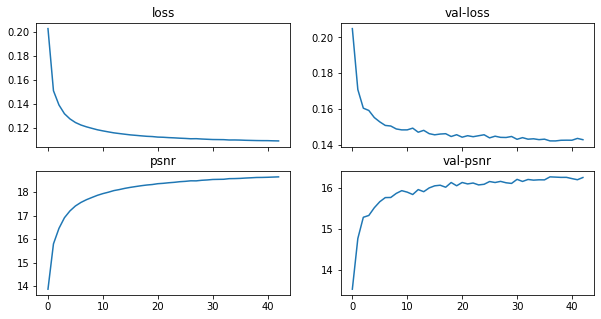

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("psnr")
ax[1, 1].set_title("val-psnr")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['psnr'])
ax[1, 1].plot(history.history['val_psnr'])

- 마지막으로 tensorboard로 요약한 이미지를 출력합니다.(마지막 에포크)

c:\users\82108\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


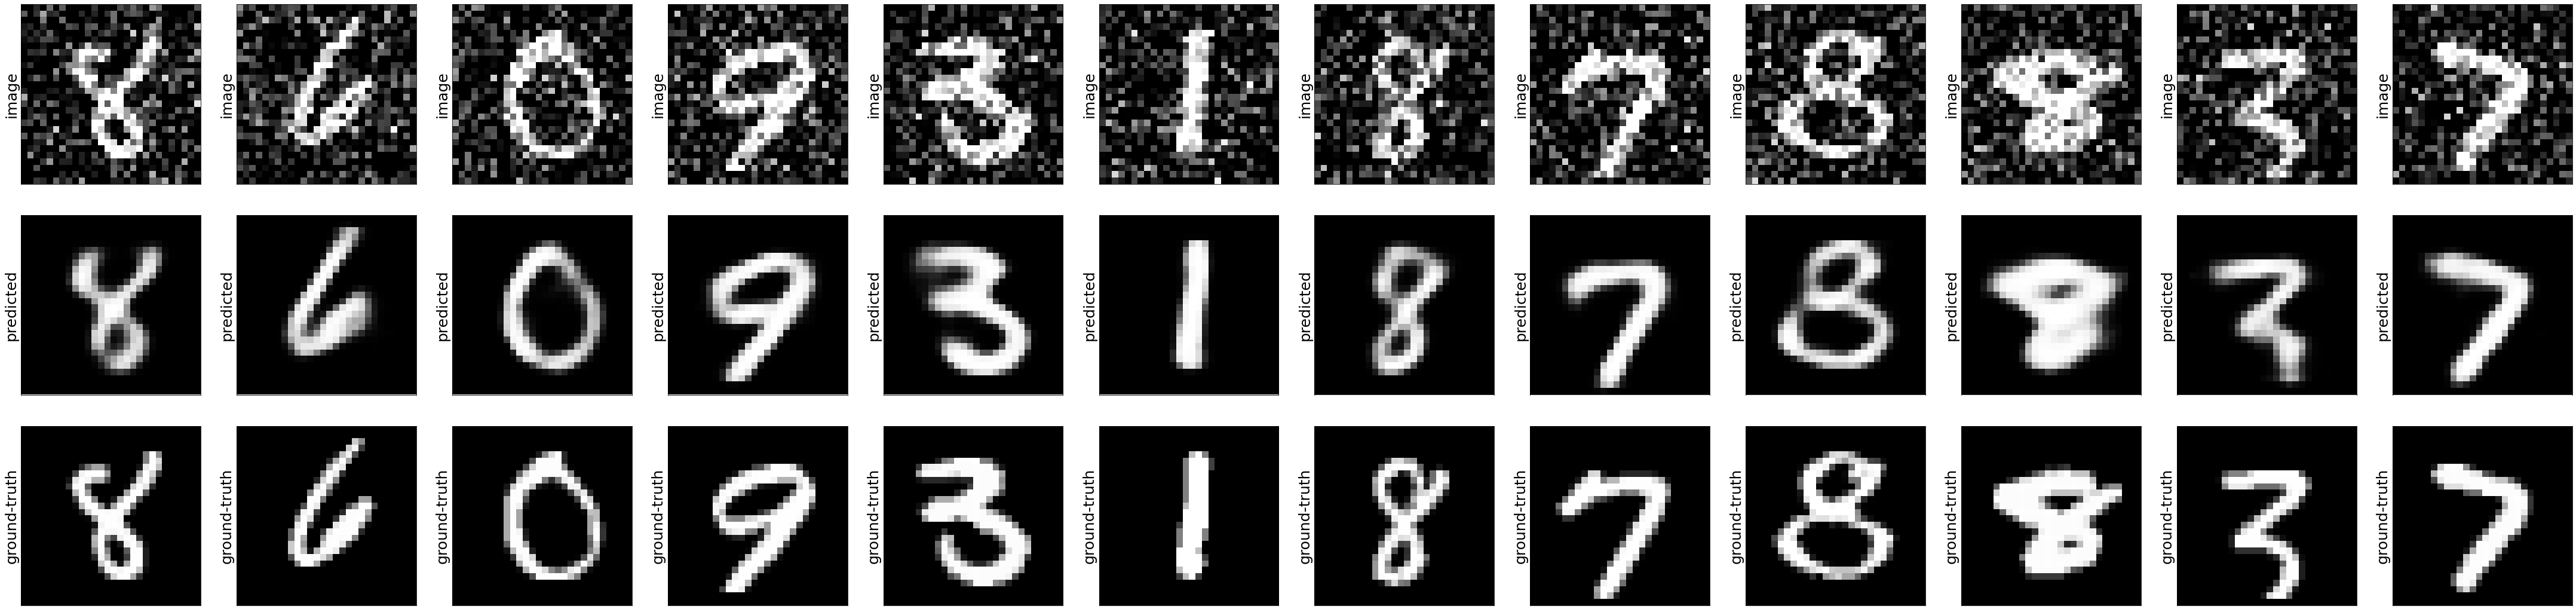

In [30]:
predicted_samples = autoencoder.predict_on_batch(noisy_samples)

fig = plot_image_grid([np.squeeze(noisy_samples),
                       np.squeeze(predicted_samples),
                       np.squeeze(orig_samples)],
                      titles=['image', 'predicted', 'ground-truth'],
                      grayscale=True, transpose=True)
fig.show()

- 보시다시피, 노이즈 제거가 완벽하지 않고 정보가 손실되는 경우도 있지만 단순화된 자동 인코더는 잘 작동되고 있습니다. 다음 섹션에서는 이미지 super-resolution이라는 보다 복잡한 문제를 해결하기 위한 **고급 컨볼루션 네트워크**를 구현할 예정입니다.

## Convolutional encoders-decoders


- convolution과 pooling 층이 소개되면서 encoder-decoder는 많은 이점을 얻었는데, 이를 활용한 auto-encoder를 Deep auto-encoder라고 하고 복잡한 작업에서 많이 활용됩니다.
- 이번 섹션에서는 convolutional encoder-decoder를 위해 개발된 새로운 층을 소개하고, 이 작업을 기반으로 몇 가지 중요한 구조를 구현합니다.

### Unpooling, transposing and dilating

- convolutional layer는 입력 텐서를 받아 더 고차원의 feature map으로 변환할 때, pooling 층은 점진적으로 데이터를 down-sample해서 작고 semantic하게 풍부한 feature로 이끕니다.
- 그래서, CNN은 성능 좋은 encoder를 만든다.


- 그럼 어떻게 low-dimentional feature를 decode를 통해 full image로 바꿀까요? 앞서 구현한 것과 같이 이미지의 encoding을 위한 dense later가 convolution과 pooling으로 대체됩니다. decoding된 feature는 **transposed convolution(deconvolution), dilated convolution, unpooling**을 통해 개선됩니다.

#### Transposed convolution(deconvolution)


- convolution시, 하이퍼 파라미터(kernel size k, input depth D, number of kernels N, padding p, and stride s)는 출력값의 크기에 영향을 줍니다. 
- 입력 텐서의 shape이 (H,W,D)라고 할 때, 출력값 shape을 ($H_o , W_o, N$)로 계산하는 방정식을 다음을 통해 확인할 수 있습니다.

$$H_o =\ {H-k+2p \over s} +1  \\\\\\\,  W_o =\ {W-k+2p\over s} +1$$

- ($H_o , W_o, N$)의 feature map과 똑같은 하이퍼 파라미터(k, D, N, p,s)이 주어질 때 우리는 (H,W,N)형태의 텐서를 복구하기 위한 컨볼루션 같은 작업을 원합니다.
- 이전 방정식에서 H와 W를 격리하여 다음 특성을 유지하는 작업을 수행하고자 합니다.

$$H =\ (H_o-1)s+k-2p  \\\\\\\,  W =(W_o-1)s+k-2p $$

- Transposed conv을 하기 위해, 입력 텐서는 먼저 dilation을 해야합니다.
- dilation은 **rate d**로 정의되어지는데, 입력텐서의 행과 열 사이를 d-1만큼 떨어트려 빈 공간을 0으로 채우는 방식이다.
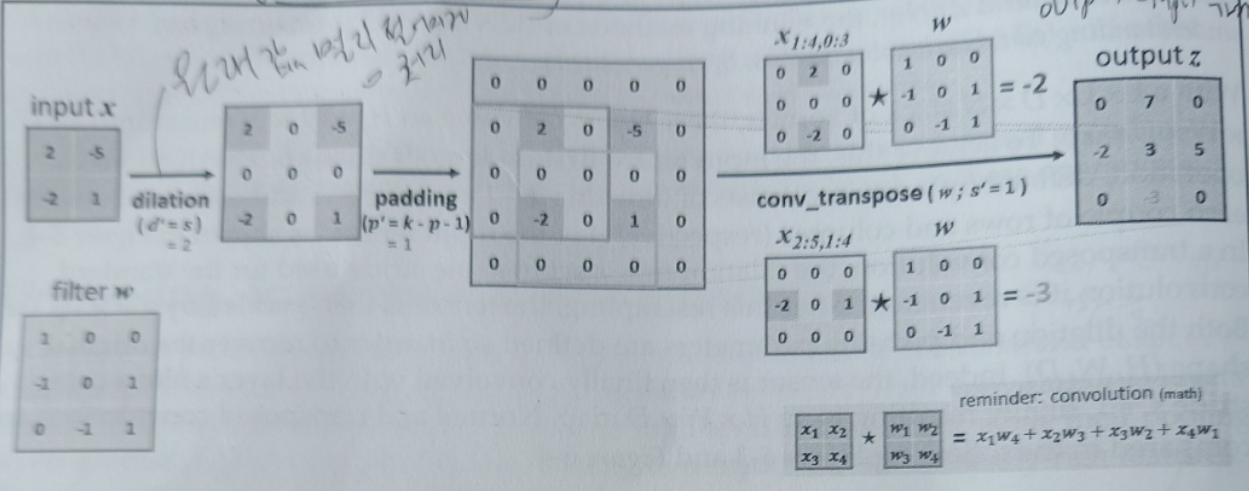

- 그림처럼 rate= s(stride)로 설정해준다 
- resampling 후에, 텐서는 p'=k-p-1로 패딩됩니다. dilation 과 padding 파라미터 모두 원본 shape(H,W,D)으로 복구하기 위해 정의되어집니다.
- 후에 s'=1로 convolution을 진행합니다.

- transposed convolution은 기본적인 convolution과 같은 방식을 사용합니다. 이러한 구조는 decoder 구조에 적합합니다.

- tf.layers.conv2d_transpose(), tf.keras.layers.Conv2DTranspose()를 사용해 transpose convolution을 사용할 수 있습니다.

#### Unpooling

- CNN 구조에서 사용되는 average-pooling, max-pooling은 영상의 공간 차원을 축소합니다.
- max-pooling의 역방향으로 제안된 **max-unpooling**은 deconvnet이라고 불리는 네트워크에 사용됩니다.
- deconvnet은 decode하고 convnet의 feature를 시각화하는데 사용됩니다.
- 구현을 위해, 먼저 max-pooling 각 층을 수정해 결과 텐서를 따라 풀링 마스크를 출력하도록 했다.
- 이 마스크는 선택된 최대값의 원래 위치를 나타냅니다.
- max-unpooling은 pooling된 tensor 및 pooling mask를 입력으로 받아 작업을 수행합니다. 
- pooling mask에 pooling된 tensor를 넣어줍니다.

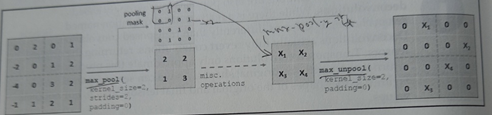

#### Upsampling and resizing

- average-unpooling은 average pooling을 모방해 만들어졌는데, average-pooling을 통해 나온 값을 복사해서 확장합니다.

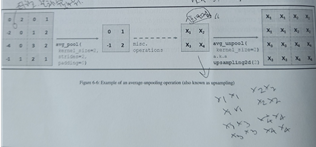

- max-pooling보다 현재 자주 쓰이고 upsampling으로 알려져있습니다.
- tf.keras.laters.Upsampling2D()로 사용가능합니다.
- upscaling에는 bilinear interpolation도 있습니다. - 훈련을 위한 파라미터를 추가할 필요가 없습니다.
    - 위의 메서드에 파라미터로 interpolation='bilinear'로 사용


- decoder 구조에서, nearest-neighbor 혹은 bilinear upscaling은 일반적으로 stride=1, padding=same으로 컨볼루션 합니다.
- 미리 정의된 upscaling과 convolutional 작업은 encoder의 convolution과 pooling layer를 흉내냅니다.
- decoder가 target signal로 더 잘 복구하기 위해 스스로의 feature를  학습하도록 합니다.

#### dilated/atrous convolution

- feature map을 upsample 하는 것이 아닌 데이터의 공간 차원의 희생없이 convolution의 receptive field를 확장합니다.
- 이러한 dilated는 transposed conv에서 소개한 내용과 유사합니다.


- 여기서는 dilated의 인수 d를 2로 지정해 receptive field를 증가시킵니다.


- tf.layers.conv2d(), tf.keras.layers.Conv2D()에서 rate 파라미터가 dilation 인수로 사용됩니다.
- default값은 1로, 1인 경우 보통의 convoltion입니다.

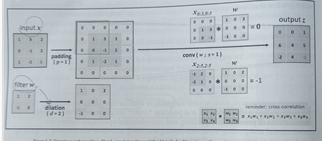

## Exemplary architectures - FCN and U-Net


- 컨볼루션 encoder-decoder는 기본적인 fully-connected 구조를 따르지만 높은 품질 결과를 위해 로컬로 연결된 층의 공간 속성을 활용합니다.
- 이번 섹션에서는 기본적인 템플릿을 기반으로한 두 가지 발전된 구조를 다룹니다.
- 2015년에 알려진 모델로 FCN과 U-Net으로 복잡한 시스템에 구성요소로 사용됩니다.


#### Fully Convolutional Networks

- AlexNet, VGGNet 등 이미지 분류(image classification)용 CNN 알고리즘들은 일반적으로 컨볼루션 층들과 fully connected 층들로 이뤄져있다. 항상 입력이미지를 네트워크에 맞는 고정된 사이즈로 작게 만들어서 입력해준다. 그러면 네트워크는 그 이미지가 속할 클래스를 예측해서 알려준다. 아래 그림에서 네트워크는 입력된 이미지의 클래스를 얼룩무늬 고양이(tabby cat)라고 예측해냈다. 

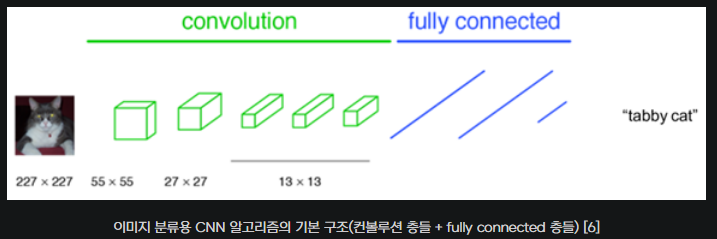


- 이러한 모델 구조는 실제로 머신러닝 교과서의 분류 문제를 다룰때 basic한 구조로 활용한 것을 이미 확인했습니다.
- 이 분류용 CNN 알고리즘들은 이미지에 있는 물체가 어떤 클래스에 속하는지는 예측해낼 수 있지만, 그 물체가 어디에 존재하는지는 예측해낼 수 없다. 왜냐하면 네트워크 후반부의 fully connected 층에 들어서면서 위치정보가 소실되었기 때문이다.(feature map의 행렬이 1차원으로 축소되어서) 따라서 AlexNet, VGGNet 등과 같은 알고리즘들을 수정함없이 Semantic segmentation 과제에 그대로 사용하는 것은 불가능하다.  

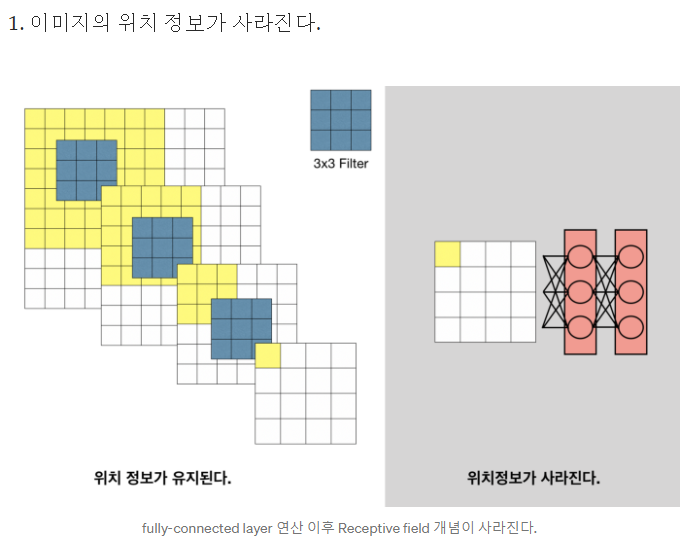



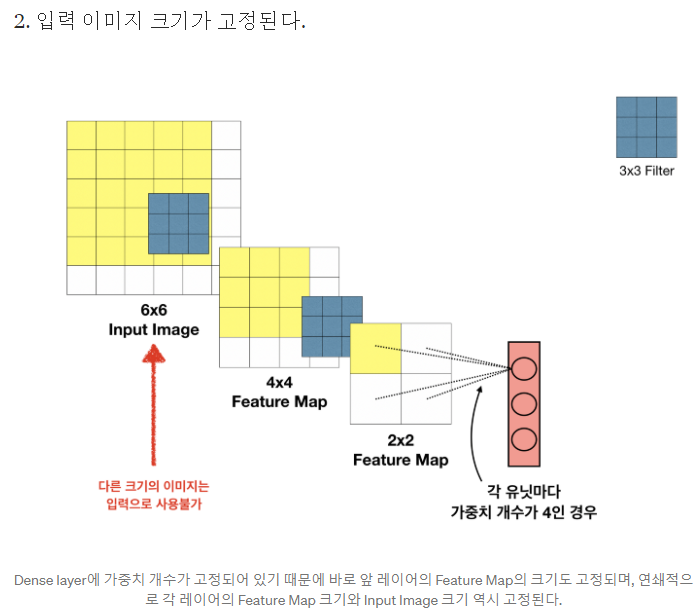


- FCN 개발자들은 위치정보가 소실되지 않게 하기 위해서, 또한 어떠한 크기의 입력이미지도 허용하기 위해서 다음과 같이 알고리즘을 발전시켜간다. 먼저 고정된 크기의 인풋만을 허용하는 fully connected 층을 1x1 컨볼루션층으로 바꿔준다. 
 
 
 - 결과적으로 네트워크 전체가 컨볼루션층들로 이뤄지게 되었다. fully connected 층들이 없어졌으므로 더 이상 입력 이미지의 크기에 제한을 받지 않게 되었다.


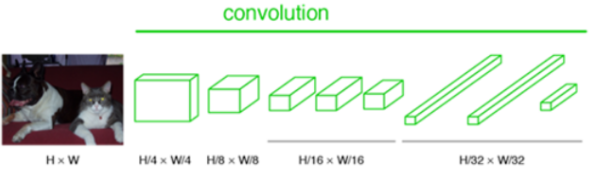

- 이제 어떠한 사이즈 H x W의 이미지도 이 네트워크에 입력될 수 있다. 여러 층의 컨볼루션층들을 거치고 나면 특성맵(feature map)의 크기가 H/32 x W/32가 되는데, 그 특성맵의 한 픽셀이 입력이미지의 32 x 32 크기를 대표한다. 즉, 입력이미지의 위치 정보를 '대략적으로' 유지하고 있는 것이다. 

 

- 여기서 중요한 것은 이 컨볼루션층들을 거치고 나서 얻게 된 마지막 특성맵의 갯수는 훈련된 클래스의 갯수와 동일하다는 것이다. 21개의 클래스로 훈련된 네트워크라면 21개의 특성맵(이것을 heatmap이라고도 부른다)을 산출해낸다. 각 특성맵은 하나의 클래스를 대표한다. 만약 고양이 클래스에 대한 특성맵이라면 고양이가 있는 위치의 픽셀값들이 높고, 강아지 클래스에 대한 특성맵이라면 강아지 위치의 픽셀값들이 높다. 



- final layer에서 대략적인(coarse) 특성맵들의 크기를 원래 이미지의 크기로 다시 복원해줄 필요가 있다. 이미지의 모든 픽셀에 대해서 클래스를 예측하는 dense prediction을 해주는 것이 semantic segmentation의 목적이기 때문이다. (coarse와 dense는 서로 반의어다.) 이 원래 이미지 크기로 복원하는 과정을 upsampling이라고 부른다
- upsampling을 통해 각 클래스에 해당하는 coarse한 특성맵들을 원래 사이즈로 크기를 키워준다. upsampling된 특성맵들을 종합해서 최종적인 segmentation map을 만든다. 간단히 말해서, 각 픽셀당 확률이 가장 높은 클래스를 선정해주는 것이다.


- 그런데 단순히 upsampling을 시행하면, 특성맵의 크기는 원래 이미지 크기로 복원되고, 그것들로부터 원래 이미지 크기의 segmentation map을 얻게 되지만 여전히 coarse한, 즉 디테일하지 못한 segmentation map을 얻게 된다. 1/32만큼 줄어든 특성맵들을 단숨에 32배만큼 upsampling 했기 때문에 당연히 coarse할 수 밖에 없다. 이렇게 단숨에 32배 upsampling하는 방법을 논문에서는 FCN-32s라고 소개하고 있다.


- 책 200쪽의 그림의 가장 위의 계층과 바로 밑의 FCN-32s 계층을 좀 더 한눈에 알아볼 수 있게 그림으로 나타내면 다음과 같습니다.
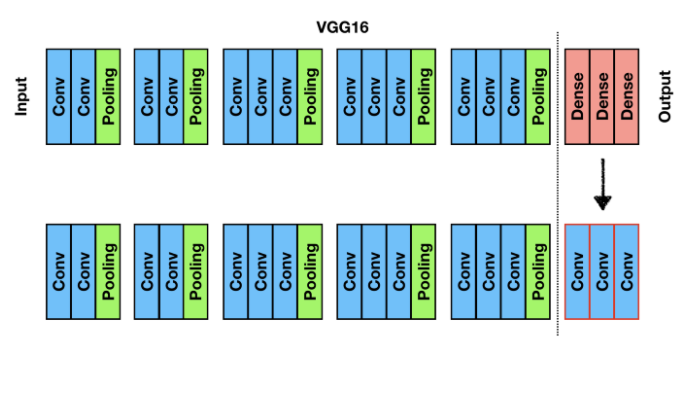

![FCN Architecture](./notebook_images/fcn.png)

#### Skip-connection 개념 추가

- CNN과 같은 이미지 처리 모델에서는 얕은 층에선 local feature(직선 및 곡선 등의 낮은 수준 특성)를 깊은 층에선 global feature(복잡한 높은 수준 특성)를 감지한다고 볼 수 있다. FCNs 연구팀은 이러한 직관을 기반으로 앞에서 구한 Dense map에 얕은 층의 정보를 결합하는 방식으로 Segmentation의 품질을 개선하였다.


- FCN-16s는 1) FCN-32s 결과를 2) 4번째 Pooling Layer의 결과(pool4)에 1*1*ch_out으로 채널을 맞춰준 후 합쳐준 뒤, 이를 stride 16으로 transpose conv해 upsampling한다. pool4이후 conv5와 pool5 단계를 건너뛰고 결과를 합쳤으므로 skip을 1번한 셈이다. (2배 x 16배)


- 비슷한 방식으로 FCN-8s는 2번의 skip을 거쳐 완성된다. 1) FCN-16s의 stride를 16이 아닌 2로 지정해 구한 결과와, 2) 3번째 Pooling Layer의 결과(pool3)를 합쳐준 뒤에 stride 8로 Upsampling한 결과이다. 일반적으로 말하는 FCN은 이 FCN-8s를 의미한다. (2배 x 2배 x 8배)

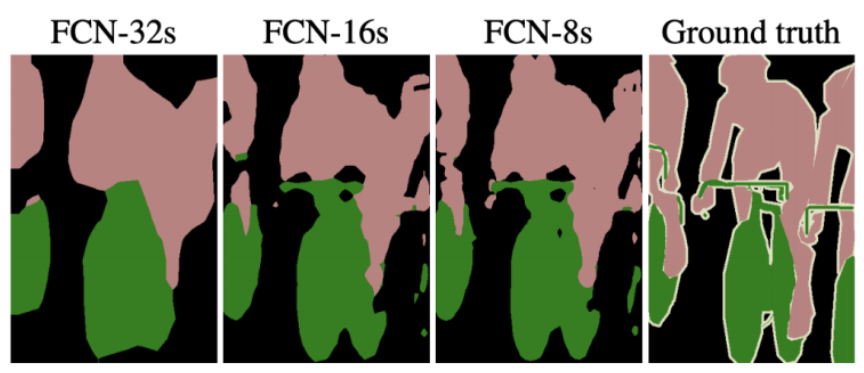

In [ ]:
def fcn_8s(image_size, ch_in=3, ch_out=3):
    """
    Build a FCN-8s Keras model, with the VGG-16 layers pretrained on ImageNet.
    :param image_size:  Image size (H x W)
    :param ch_in:       Number of input channels
    :param ch_out:      Number of output channels
    :return:            Keras model
    """
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  # shape: (28, 28, 256)
    f4 = vgg16.get_layer('block4_pool').output  # shape: (14, 14, 512)
    f5 = vgg16.get_layer('block5_pool').output  # shape: ( 7,  7, 512)

    # Replacing VGG dense layers by convolutions:
    f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f5_drop2)


    # Using a transposed conv (w/ s=2) to upscale `f5_conv3` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5_conv3)
    # Note: if your machine is not performant enough or if you want to run a lighter version,
    #       you can short-circuit the `f5_convX` layers and directy upscale `f5` instead:
    # f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
    #                             use_bias=False, padding='same', activation='relu')(f5)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4) #skip-connection

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1, f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3) #skip-connection
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8,
                              padding='same', activation=None)(merge2)
    
    fcn8s_model = Model(inputs, outputs)
    return fcn8s_model

### U-Net


- U-Net도 semantic segmentation을 위해 개발된 모델로, feature의 깊이는 높이면서 공간 차원은 줄이는 multi-block 수축 encoder와 영상 해상도를 복구하는 확장된 decoder로 구성되어 있습니다.
- 게다가 FCN처럼 skip connection이 encoding block을 대칭하는 decoding와 연결하고 있습니다.


- decoding block은 바로 앞의 block으로부터의 contextual 정보와 encoding path로부터의 위치 정보를 제공받습니다.
- U-Net은 FCN과 2가지 차이가 있는데, 1) FCN과 다르게 전통적인 u-shaped encoder decoder 구조로 U-Net은 대칭합니다.
- skip connection에서 특징맵간의 결합은 concatenation에 위해 생략됩니다.



![FCN Architecture](./notebook_images/unet.png)

- 일반적으로 중간 conv 기준 왼쪽 부분을 contracting path(수축), 오른쪽 부분을 Expanding paht(팽창)이라한다.
- 이미지의 contextual 정보는 contracting path에서 정확한 localization은 expanding path에서 구해진다.


- expanding path의 경우 contracting path의 최종 특징맵으로부터 보다 높은 해상도의 Segmentation 결과를 얻기 위해 몇차례 업샘플링을 진행하며, 이는 FCN에서 봤던 coarse map에서 dense prediction을 얻기 위한 구조와 유사합니다. 
- contracting path의 특징맵은 업샘플링된 결과와 연결되어 더 정확한 localization을 가능하게 합니다.

#### Application to upscaling images


- 모델에 적용하기 전, 전통적인 upscaling 기법으로 target 차원으로 영상의 크기를 조절합니다.
- bilinear interpolation


In [ ]:
x_noisy = bilinear_upscale(bilinear_downscale(x_train))
fcn_8s.fit(x_noisy, x_train)

<tr>
    

   dad 


<tr>
    

    

    

<tr>
    

    


<tr>
    

    


# Understanding semantic segmentation

- object segmentation with encoders-decoders
    - decoding as label maps
    - Training with segmentation losses and metrics
    - post-processing with conditional ramdom fields
- Advanced example - image segmentation for self-driving cars
    - Task presentation
    - Exemplary solution


- The more difficult case of instance segmentation
    - From object segmentation to instance segmentation
        - respecting boundaries
        - post-processing into instance masks
    - From object detection to instance segmentation -Mask R-CNN
        - Applying semantic segmentation to bounding boxes
        - Building an instance  model from Faster-RCNN
        

- sementic segmentation은 의미있는 영역에서 영상을 분할하는 것으로 픽셀 수준의 dense한 prediction을 요구합니다. 즉, 입력 이미지의 각각의 픽셀에 레이블을 부여해야합니다.
- semantic segmentation에 encoder -decoder가 적절한지 알아보고 더 복잡한 instance segmentation의 해결책을 알아봅니다.

# object segmentation with encoders-decoders


- encoding-decoding 네트워크는 데이터 샘플을 하나의 다른 도메인으로 매핑하도록 학습됩니다. object segmentation은 컬러 도메인에서 클래스 도메인으로 이미지를 매핑합니다. 값과 context가 주어지면, 영상의 각각의 픽셀에 타겟 클래스 중 하나를 할당해 높이와 너비가 같은 label map을 반환합니다.

- encoder와 decoder가 영상을 받고 label map을 반환하는 것은 뒤에서 디테일하게 다루겠습니다.


### Overview


- U-Net 같은 네트워크가 어떻게 object-segmentation에 사용되는지 확인하고 수정된 label maps에서 어떻게 출력값이 처리되는지 알아봅니다.

### Decoding as label maps


- 각각의 픽셀 값이 클래스를 나타내는 출력 label map를 encoder-decoder에 직접적으로 연결하면 나쁜 성능을 나타낼 것입니다. 분류기와 같이, output categorical value를 다룰 더 나은 방법이 필요합니다.


- N개의 카테고리로 영상을 분류하기 위해, 우리는 N개의 로짓들을 출력하는 최종 레이어로 네트워크를 구축하는 것을 배웠고, 이는 클래스별 예상 점수를 나타냅니다. 이러한 점수를 학률로 변환하기 위해 softmax 활성함수를 사용했고 가장 높은 확률을 가진 클래스를 선택하는 방법을 픽셀 수준의 semantic segmetation에서도 사용합니다. 


- 각 전체 영상에 대한 클래스별 점수가 포함된 N 로짓의 열 벡터를 출력하는 대신, 저자의 네트워크는 각 픽셀에 대한 점수가 있는 (H x W x N)텐서를 반환하도록 구축되었습니다

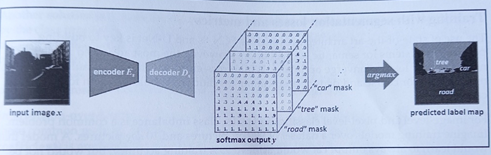

- 위의 구조에서 출력값의 채널 개수는 클래스 개수와 같습니다.(D_0 = N)
- 분류기처럼 학습되어집니다.
- cross-entropy loss는 one-hot-encoded ground-truth(정답) label maps와 softmax 값을 비교하는데 사용됩니다.
- 또한 H,W,N 크기의 예측은 채널 축을 따라 가장 높은 값을 선택하여 픽셀 단위 라벨로 유사하게 변환될 수 있습니다.(argmax)


- FCN-8s 코드는 손쉽게 object segmentation 모델 학습에 적용가능합니다.

In [ ]:
inputs = Input(shape=(224, 224, 3))
out_ch = num_classes = 19 # e.g., for object segmentation over Cityscapes 출력 채널과 클래스 수가 같다
# [...] building e.g. a FCN-8s architecture, c.f. previous snippet.
outputs = Conv2DTranspose(filters=out_ch, kernel_size=16, strides=8,
 padding='same', activation=None)(m2)
seg_fcn = Model(inputs, outputs)
seg_fcn.compile(optimizer='adam', loss='sparse_categorical_crossentropy') #정수형 분류 
# [...] training the network. Then we use it to predict label maps:
label_map = np.argmax(seg_fcn.predict(image), axis=-1) #2차원 채널 기준 행에 대하여 max 비교 후 인덱스 반환

# ------------ 여기부터 다시 시작 --------------

## Training with segmentation losses and metrics

- 개선된 모델이 최적으로 수렴하기 위해서는 여전히 적절한 loss가 필요합니다.
- 이미지 수준의 분류나 픽셀 수준의 분류에서 class imbalance는 공통된 문제입니다.

- 990개의 고양이 영상과 10개의 개 영상으로 된 데이터셋으로 학습을 한다면, 모델은 고양이에 대한 학습 정확도를 99%로 달성합니다. 하지만 이는 크게 유용하지 않을 것입니다.
- image classification에서는, 영상을 추가하거나 제거함으로써 이를 피할 수 있습니다. 이를 통해 모든 클래스가 똑같은 비율로 나타내어집니다.
- 픽셀 수준 분류의 경우 문제가 더 까다롭습니다.
- 일부 클래스는 모든 이미지에 나타날 수 있지만 일부 픽셀에만 적용되는 반면, 다른 클래스는 대부분의 이미지를 포함할 수 있습니다.(예를들어, 신호등과 길의 픽셀을 비교해보면 길을 나타내는 픽셀의 크기는 매우 큰 반면 신호등을 나타내는 픽셀의 크기는 매우 작습니다.)
- 이러한 imbalance를 보완하기 위해 데이터 집합을 편집할 수 없습니다.

- segmentation 모델이 더 큰 클래스에 대한 bias가 생기는 것을 방지하지 위해, 손실 함수를 조정해야 합니다.
- 더 적게 나오는 물체에 대해서 더 높은 가중치를 부여합니다. 이 방식을 통해 문제를 해결할 수 있습니다.
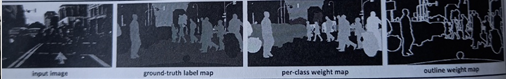

- 이 weight map은 대체로 ground-truth label map으로부터 계산됩니다. 위 그림을 보면 클래스에 대해서만 가중치를 부여한 것이 아닌 각 픽셀의 상대적인 위치에 따라서도 가중치를 부여합니다.

- 다른 해결책은 cross-entropy를 미분하기에 대체하는 cost function을 찾는 것으로, cross-entropy는 accuracy function의 대체용입니다. 왜냐하면, 미분하기 쉬워 채택되었습니다.
- 하지만, 이 함수는 우리의 모델의 실제 물체를 표현하지 못하고, 다른 클래스들과 제대로 분리하지 못합니다. 그러므로, 더 정확한 함수를 찾아야 합니다.

- Sorensen-Dice coefficient는 IoU를 닮은 metrics가 있는데 이것의 수식은 다음과 같습니다.
$$Dice(A,B) =\ {{2|A \cap B|} \over {|A| + |B|}}$$

- |A|, |B|는 각 세트의 수를 나타내고, $|A \cap B|$ 는 겹친 element의 수를 나타냅니다. IoU와 Dice의 관계는 다음 수식과 같습니다.

$$IoU(A,B) =\ {{Dice(A,B)} \over {2-Dice(A,B)}};\   Dice(A,B) =\ {{2xIoU(A,B)}\over{1+ IoU(A,B)}}$$


- Dice는 예측한 mask와 ground truth가 얼마나 겹치는지 측정해주는 것이다. 분자는 올바르게 분류된 픽셀의 수를 나타내고, 분모는 예측한 mask와 ground-truth mask에 포함된 픽셀의 숫자를 나타냅니다.
- 수식에서 Dice coefficient가 0~1 사이의 값으로 정의되었고, 0에 가까워질 수록 덜 겹쳐진다는것을 알 수 있습니다.
- 손실함수는 이를 minimize하는데 사용해야되므로 이 숫자의 역을 구해야합니다. 그 수식은 다음과 같이 정의됩니다.
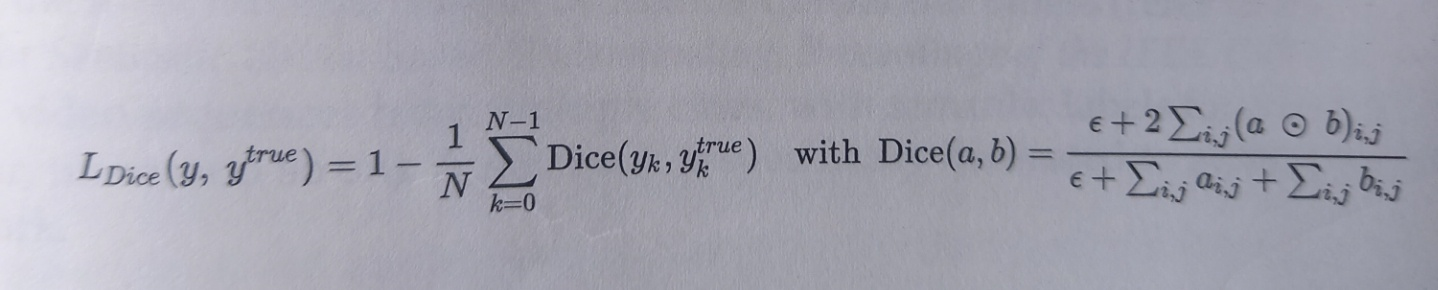

- 분자는 a,b(2개의 one-hot tensor)의 element-wise multiplication하고 모두 더해준 값과 근접할 것이고, 분모는 a,b의 모든 element를 더한 결과입니다. 마지막으로 $\epsilon $은 0이 되지 않도록 더해주는 매우 작은 값입니다.

In [ ]:
def dice_loss(y_true, y_pred, ignore_value=CITYSCAPES_IGNORE_VALUE,
              eps=1e-6, spatial_axes=[1, 2], from_logits=False):
    """
    Compute the Dice loss for semantic segmentation, ignoring pixels from some misc. classes.
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
    :param eps:           Epsilon small value (smooth) 
    :param spatial_axes:  Spatial axes
    :param from_logits:   Flag if predictions are logits (not normalized)
    :return:              Loss value
    """
    num_classes = y_pred.shape[-1]# 예측값의 채널 수
        
    # (opt.) Build mask to remove pixels from ignored classes:
    # if ignore_value is not None:
    #     y_true, y_pred = prepare_data_for_segmentation_loss(
    #         y_true, y_pred, num_classes=num_classes, ignore_value=ignore_value)

    # Transform logits in probabilities, and one-hot the ground-truth:
    if from_logits:
        y_pred = tf.nn.softmax(y_pred, axis=-1) #로짓으로 부터 확률값을 구함
    y_true = tf.squeeze(tf.cast(y_true, tf.int32), axis=-1)
    y_true_onehot  = tf.one_hot(y_true, num_classes, dtype=y_pred.dtype) #인덱스를 받아 원핫 인코딩 생성

    # (opt.) Build mask to remove pixels from ignored classes:
    if ignore_value is not None:
        mask_for_valid_labels = get_mask_for_valid_labels(
            y_true, num_classes, ignore_value=ignore_value)
        mask_for_valid_labels = tf.cast(mask_for_valid_labels, y_pred.dtype)
        mask_for_valid_labels = tf.expand_dims(mask_for_valid_labels, axis=-1)
        y_pred = y_pred * mask_for_valid_labels
        y_true_onehot = y_true_onehot * mask_for_valid_labels

    # Compute Dice numerator and denominator(분자,분모):
    #먼저 두번째 차원 더하면서 축소 후  세번째 차원 축소
    num_perclass = 2 * tf.reduce_sum(y_pred * y_true_onehot, axis=spatial_axes) 
    den_perclass = tf.reduce_sum(y_pred + y_true_onehot, axis=spatial_axes)

    # Compute Dice and average over batch and classes:
    dice = tf.reduce_mean((num_perclass + eps) / (den_perclass + eps))

    return 1 - dice


In [21]:
import tensorflow as tf
import numpy
x = tf.constant([[[1, 1, 1], [1, 1, 1]]])
x.numpy()
print(x)
# 모든 요소의 합
# 1 + 1 + 1 + 1 + 1+ 1 = 6
tf.reduce_sum(x,[1,2]).numpy()

tf.Tensor(
[[[1 1 1]
  [1 1 1]]], shape=(1, 2, 3), dtype=int32)


array([6])

### Post-processing with conditional random fields

- 모든 픽셀을 레이블링 하는 것은 복잡한 일이고 predicted label을 mapping 하는 것은 안 좋은 윤곽선과 맞지 않은 작은 영역들로 predicted label mapping을 얻는 것은 똑같이 복잡한 일입니다.
- 다행히도, 결함을 수정하고 결과를 후처리하는 방법이 있습니다. 이 방법은 conditional random field(CRFs)방식인데 가장 흔하고 효율적입니다.


- CRFs는 원본 이미지에서 각 픽셀의 context를 고려해 픽셀 수준의 예측을 증가시킵니다. 이웃한 두 픽셀 사이의 color gradient가 작으면(색의 갑작스러운 변화가 없음) 같은 클래스로 분류합니다. 공간 및 색상 기반 모델과 예측 변수가 제공하는 확률 맵을 고려하면 CRFs 방법은 시각적 윤곽선과 관련해 더 나은 정제된 레이블 맵을 반환합니다.

### Advanced example-image segmentation for self-driving cars

- 자율 주행차를 위해 교통 이미지의 segmentation을 해봅니다.


#### Task presentation

- 사람들이 운전하는 것처럼, 자율 주행차는 그들의 환경과 주변 요소를 인지하고 이해할 필요가 있습니다.
- 전방 카메라로부터 비디오 이미지에 semantic segmentation을 적용하는 것은 시스템으로부터 자율주행차가 주변에 다른 차가 있는지, 길을 건너는 보행자나 자전거가 있는지, 교통 안내선이나 신호 등등을 알도록 합니다.
- 여러 관련 데이터 세트 및 벤치 마크를 사용할 수 있는데 그 중 cityscapes을 선택합니다.
- 이 데이터셋은 여러 도시의 모습과 19개 이상의 semantic label을 제공합니다.

- 챕터에서 소개된 FCN이나 U-Net 코드는 앞으로의 과정에서 학습에 문제를 일으킵니다. 이 섹션에서 몇가지 트릭을 사용합니다.  우리는 각 클래스가 loss를 계산할 때 어떻게 적절한 가중치를 부여하는지 보여주고, label map을 어떻게 후처리 하는지 보여줄 것입니다.

### The more difficult case of instance segmentation

- object segmenation을 위해 모델을 학습시키면서, softmax 출력은 각 픽셀에 대해 N 클래스 중 하나에 속할 확률을 나타냅니다.
- 하지만, 두 개의 픽셀 또는 픽셀 덩어리가 클래스의 동일한 인스턴스에 속하는 경우 표시되지 않습니다. 예를 들어 p205의 그림에 표시된 예측 레이블 맵이 주어졌을 때, 우리는 건물이나 나무 인스턴스의 수를 셀 방법이 없습니다.

- 다음 하위 섹션에서 이미 해결한 두 가지 관련 작업, 즉 객체 분할 및 객체 감지에 대한 솔루션을 확장함으로써 instance segmentaion의 두 가지 다른 방법을 소개합니다. 

### From object segmentation to instance segmentation

- 먼저, 우리가 앞서 다룬 segmentatino 모델로부터 instance mask를 얻는 몇 가지 tool을 소개합니다.
- U-Net 저자들은 출력을 인스턴스 분할에 사용할 수 있도록 인코더-디코더 튜닝 아이디어를 대중화했습니다.

#### Respecting boundaries

- 만약 element가 semantic mask에 의해 잘 분리되고 오버래핑 되지 않는다면, 각각의 물체를 구분하기 위해 마스크를 나누는 것은 어렵지 않습니다. 몇몇 알고리즘은 뚜렷한 경계선을 예측할 수 있게 만들고 각 blob에 대해 분리된 마스크를 제공합니다. multi-class instance segmentation에 대해 이 과정은 instance별로 나누기 위해각각의 클래스마다 반복될 것이고 mask는 segmentation 방식에 의해 반환 받을 것입니다.


- 그러나 정확한 시맨틱 마스크를 먼저 확보해야 합니다. 그렇지 않으면 너무 가까운 element가 단일 blob으로 반환될 수 있습니다.
- 그렇다면 segmentation 모델이 최소한 겹치지 않는 element에 대해 정확한 윤곽선을 가진 마스크를 생성하는 데 충분한 주의를 기울이도록 하려면 어떻게 해야 할까요? 우리는 이미 답을 알고 있습니다. 네트워크가 특정 작업을 수행하도록 가르치는 유일한 방법은  training loss을 적절히 조정하는 것입니다.


- U-Net은 현미경 영상에서 신경 구조를 분할하기 위해 생체의학 응용을 위해 개발되었습니다. 저자들은 네트워크가 가까운 위치에 존재하는 세포를 제대로 분리하도록 가르치기 위해 손실 함수의 가중치를 두어 잘못 분류된 픽셀을 여러 instance의 경계에서 더 심하게 패널티를 주는 것으로 결정했다.
- 또한 p206의 그림에 설명된 이 전략은 이전 하위 섹션에서 설명한 클래스당 손실 가중치와 상당히 유사하지만, 여기서는 각 픽셀에 대한 가중치가 구체적으로 계산됩니다. U-Net 작성자는 ground-truth class mask를 기반으로 이러한 가중치 맵을 계산하는 공식을 제공합니다.
- 각 픽셀과 각 클래스에 대해 이 공식은 가장 가까운 두 클래스 인스턴스의 픽셀 거리를 고려합니다. 두 거리가 작을수록 가중치가 커집니다.
- 가중치 map은 사전에 계산되고 학습 중에 함께 사용할 ground-truth mask를 따라 저장될 수 있습니다.


- 이 픽셀당 가중치는 다중 클래스 시나리오에서 클래스당 가중치와 결합될 수 있습니다. 


- 각 클래스에 대해 사용자 정의 U-Net은 **픽셀당 클래스 확률을 예측하는 일반 마스크** 와 **클래스 경계를 캡처하는** 두 개의 마스크를 출력했습니다.
- ground-truth boundary 마스크는 class 마스크를 기반으로 사전 계산되었습니다.
- 적절한 학습을 거친 후 예측된 두 마스크의 정보를 사용하여 각 클래스에 대해 잘 분리된 element를 얻을 수 있습니다.



#### Post-processing into instance masks

- 앞 절에서 설명한 것처럼 정밀한 마스크가 확보되면 적절한 알고리즘을 적용하여 중복되지 않는 인스턴스를 식별할 수 있습니다.
- 이러한 후처리는 일반적으로 마스크 침식 및 확장과 같은 형태론적 함수를 사용하여 수행됩니다. ( erosion, dilation)

- Watershed transforms은 class mask를 instance로 추가 분할하는 또 다른 공통 알고리즘입니다. 이러한 알고리즘은 단일 채널 tensor를 사용하며 각 값이 높낮이를 나타내는 지형 표면으로 간주합니다.
- 위 방법은 이번 챕터에서 사용되지 않지만 다양한 방법을 사용해 높낮이의 가장 위를 추출하여 인스턴스 경계로 나타냅니다.


- FCN 구조에서 영감을 받아, 네트워크에서는 예측된 semantic 마스크와 원본 RGB 이미지를 모두 입력하며, 능선을 식별하는 데 사용할 수 있는 energy map을 반환합니다
- 이 해결책은 RGB 정보 덕분에 중복 인스턴스도 우수한 정확도로 분리할 수 있습니다.

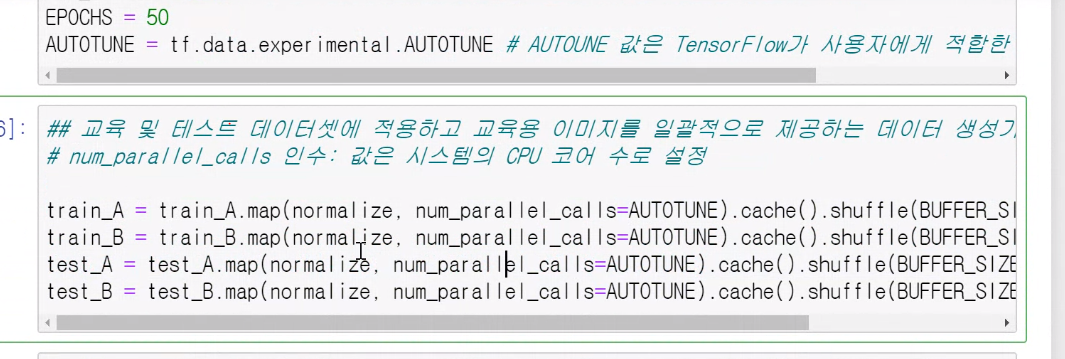